Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Training dataset size: 50000
Test dataset size: 10000
Image dimensions: 3x32x32
Number of classes: 10


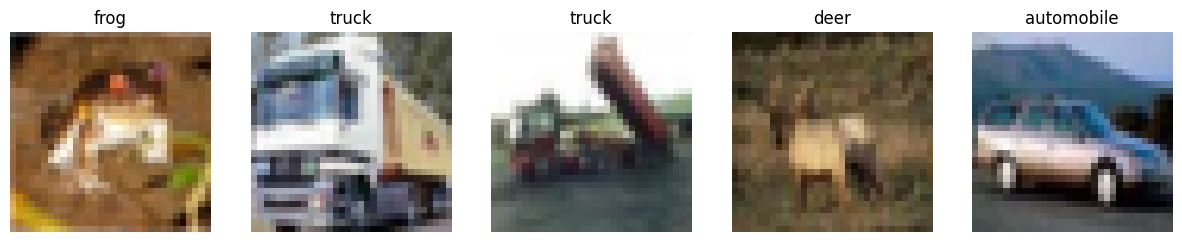

In [8]:
# Step 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Check if GPU is available and use it, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 2: Explore the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])

# Define the inverse normalization transformation
inv_normalize = transforms.Normalize(
    mean=(-1, -1, -1), 
    std=(2, 2, 2)
)

train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Display dataset size and image dimensions
print("Training dataset size:", len(train_data))
print("Test dataset size:", len(test_data))
print("Image dimensions: 3x32x32") 
print("Number of classes:", len(train_data.classes))

# Show sample images from the dataset along with labels
label_names = train_data.classes
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
for i, ax in enumerate(axes):
    image, label = train_data[i]
    image = inv_normalize(image)  # Apply inverse normalization
    image_np = image.permute(1, 2, 0).numpy()  # Convert tensor to NumPy array and transpose dimensions
    ax.imshow(image_np)
    ax.set_title(label_names[label])
    ax.axis('off')
plt.show()



In [9]:
# Step 3: Define functions for GPU training
class Cifar10CnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.device = device  # Store the device (CPU or GPU) on which the model will be trained
        self.network = nn.Sequential(  
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # First convolutional layer: input channels=3, output channels=32, kernel size=3x3, padding=1
            nn.ReLU(),  # ReLU activation function
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Second convolutional layer: input channels=32, output channels=64, kernel size=3x3, padding=1
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(2, 2),  # Max pooling layer: kernel size=2x2, stride=2
            nn.Dropout(0.5),  # Dropout layer with dropout rate of 0.5 (to prevent overfitting)

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # Third convolutional layer: input channels=64, output channels=128, kernel size=3x3, padding=1
            nn.ReLU(),  # ReLU activation function
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # Fourth convolutional layer: input channels=128, output channels=128, kernel size=3x3, padding=1
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(2, 2),  # Max pooling layer: kernel size=2x2, stride=2
            nn.Dropout(0.5),  # Dropout layer with dropout rate of 0.5

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),  # Fifth convolutional layer: input channels=128, output channels=256, kernel size=3x3, padding=1
            nn.ReLU(),  # ReLU activation function
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),  # Sixth convolutional layer: input channels=256, output channels=256, kernel size=3x3, padding=1
            nn.ReLU(),  # ReLU activation function
            nn.MaxPool2d(2, 2),  # Max pooling layer: kernel size=2x2, stride=2
            nn.Dropout(0.5),  # Dropout layer with dropout rate of 0.5

            nn.Flatten(),  # Flatten the output from convolutional layers into a 1D tensor
            nn.Linear(256*4*4, 1024),  # Fully connected layer: input features=256*4*4, output features=1024
            nn.ReLU(),  # ReLU activation function
            nn.Dropout(0.5),  # Dropout layer with dropout rate of 0.5

            nn.Linear(1024, 512),  # Fully connected layer: input features=1024, output features=512
            nn.ReLU(),  # ReLU activation function
            nn.Linear(512, 10)  # Output layer: fully connected layer with 10 output units 
        )
        
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        preds = torch.argmax(out, dim=1)
        correct = torch.sum(preds == labels).item()
        return {'val_loss': loss, 'val_correct': correct, 'val_total': len(labels)}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        val_correct = sum([x['val_correct'] for x in outputs])
        val_total = sum([x['val_total'] for x in outputs])
        val_acc = val_correct / val_total
        return {'val_loss': epoch_loss.item(), 'val_acc': val_acc}
    
    def epoch_end(self, epoch, result):
        pass


In [10]:
# Step 4: Define functions for GPU training
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
# Step 5: Training model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, test_loader, device, opt_func=torch.optim.SGD):
    history = []
    test_accuracies = []  # List to store test accuracies
    train_accuracies = []  # List to store train accuracies
    
    optimizer = opt_func(model.parameters(), lr)
    model.to(device)  # Ensure model is on the correct device
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        correct_train = 0
        total_train = 0
        
        for batch in train_loader:
            batch = to_device(batch, device)  # Move batch to device
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # Calculate training accuracy
            preds = torch.argmax(F.softmax(model(batch[0]), dim=1), dim=1)
            correct_train += torch.sum(preds == batch[1]).item()
            total_train += len(batch[1])
        
        train_acc = correct_train / total_train
        train_accuracies.append(train_acc)
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = train_acc
        
        # Print accuracy and validation loss for the epoch
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {result['train_loss']:.4f}, Train Accuracy: {result['train_acc']:.4f}, Validation Loss: {result['val_loss']:.4f}, Validation Accuracy: {result['val_acc']:.4f}")
        
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Calculate test accuracy
        test_result = evaluate(model, test_loader)
        test_acc = test_result['val_acc']
        test_accuracies.append(test_acc)
        print(f"Test Accuracy: {test_acc:.4f}\n")

    return history, train_accuracies, test_accuracies

In [12]:
# Step 7: Visualization of Losses and Accuracy
def plot_losses_and_accuracy(history):
    # Extracting losses and accuracy from history
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]
    train_accuracies = [x.get('train_acc') for x in history]  
    
    # Find the epoch with the highest validation accuracy
    best_epoch = np.argmax(val_accuracies)
    best_val_accuracy = val_accuracies[best_epoch]
    best_train_accuracy = train_accuracies[best_epoch]
    
    # Plotting losses
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, '-r', label='Training Loss')
    plt.plot(val_losses, '-b', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, '-r', label='Training Accuracy')
    plt.plot(val_accuracies, '-g', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Best Epoch: {best_epoch + 1}, Validation Accuracy: {best_val_accuracy:.4f}")
    print(f"Best Epoch: {best_epoch + 1}, Training Accuracy: {best_train_accuracy:.4f}")

def save_model(model, filename):
    torch.save(model.state_dict(), filename)

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))


In [13]:
# Step 8: Load CIFAR-10 dataset
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Step 9: Split the dataset into training and validation sets
val_size = 5000
train_size = len(train_data) - val_size
train_ds, val_ds = random_split(train_data, [train_size, val_size])
print(len(train_ds))
print(len(val_ds))


# Extract validation labels
val_labels = [val_ds[i][1] for i in range(len(val_ds))]

batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_data, batch_size*2, num_workers=4, pin_memory=True)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

model = to_device(Cifar10CnnModel(), device)

45000
5000


### Model Adjustments and Experimentation

In an attempt to enhance the model's performance, I tried several experiments. Initially, we experimented with adjusting the dropout layer rate to 0.2 to mitigate overfitting. However, this adjustment did not yield significant improvements in the final test accuracy.

Additionally, we iterated on the structure of our Convolutional Neural Network (CNN) model to explore potential enhancements. Despite altering the architecture to accommodate additional layers and parameters, the expected improvements did not make any notable changes in my result. 

In [14]:
# Step 10: Training the model
epochs = 80
lr = 0.001
history, train_accuracies, test_accuracies = fit(epochs, lr, model, train_dl, val_dl, test_dl, device, opt_func=optim.Adam)


Epoch [1/80], Train Loss: 1.8087, Train Accuracy: 0.3189, Validation Loss: 1.4298, Validation Accuracy: 0.4628
Test Accuracy: 0.4558

Epoch [2/80], Train Loss: 1.3414, Train Accuracy: 0.5194, Validation Loss: 1.1379, Validation Accuracy: 0.5862
Test Accuracy: 0.5774

Epoch [3/80], Train Loss: 1.1348, Train Accuracy: 0.5946, Validation Loss: 1.0563, Validation Accuracy: 0.6122
Test Accuracy: 0.6156

Epoch [4/80], Train Loss: 1.0152, Train Accuracy: 0.6466, Validation Loss: 0.9035, Validation Accuracy: 0.6784
Test Accuracy: 0.6740

Epoch [5/80], Train Loss: 0.9378, Train Accuracy: 0.6778, Validation Loss: 0.8273, Validation Accuracy: 0.7010
Test Accuracy: 0.6964

Epoch [6/80], Train Loss: 0.8702, Train Accuracy: 0.7012, Validation Loss: 0.7601, Validation Accuracy: 0.7310
Test Accuracy: 0.7207

Epoch [7/80], Train Loss: 0.8348, Train Accuracy: 0.7151, Validation Loss: 0.7474, Validation Accuracy: 0.7356
Test Accuracy: 0.7244

Epoch [8/80], Train Loss: 0.8092, Train Accuracy: 0.7286, Vali

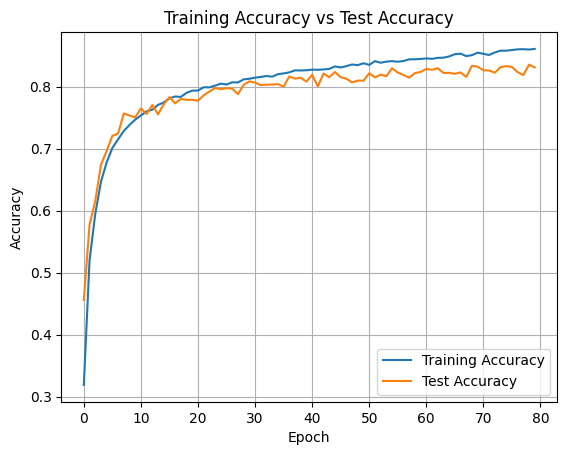

In [15]:
# Plotting training accuracy vs test accuracy
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy vs Test Accuracy')
plt.legend()
plt.grid(True)

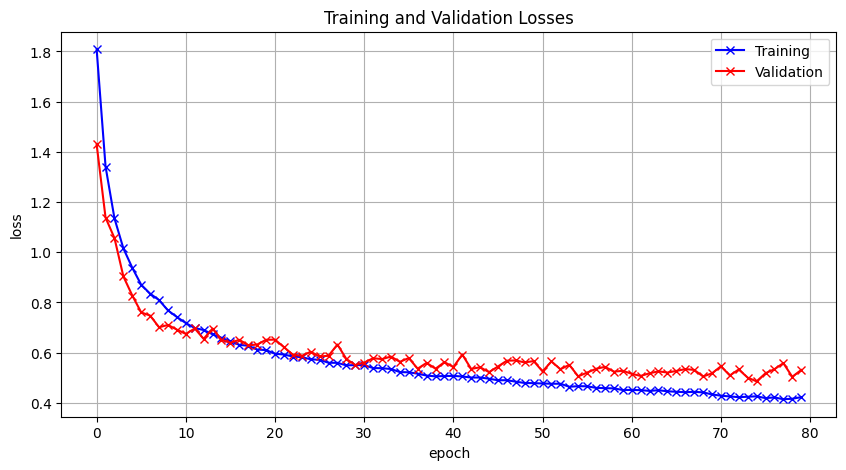

Test Loss: 0.5332576036453247
Test Accuracy: 0.8312


In [16]:
train_losses = [x['train_loss'] for x in history]
val_losses = [x['val_loss'] for x in history]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, '-bx')
plt.plot(val_losses, '-rx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.grid()
plt.show()

test_result = evaluate(model, test_dl)
print('Test Loss:', test_result['val_loss'])
print('Test Accuracy:', test_result['val_acc'])